In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter

In [2]:
from torchvision import datasets

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True
)
test_data = datasets.MNIST(
    root='data',
    train=False
)

x_train = train_data.data.detach().numpy()
y_train = train_data.targets.detach().numpy()
x_test = test_data.data.detach().numpy()
y_test = test_data.targets.detach().numpy()

print('Training image: ', x_train.shape)  
print('Testing image: ', x_test.shape)   
print('Training label: ', y_train.shape)   
print('Testing label: ', y_test.shape)     


Training image:  (60000, 28, 28)
Testing image:  (10000, 28, 28)
Training label:  (60000,)
Testing label:  (10000,)


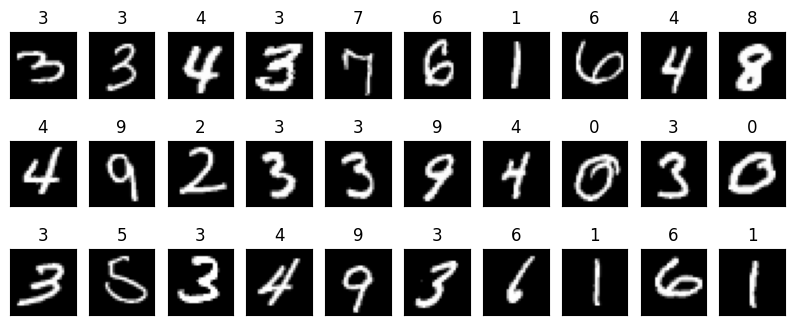

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))  

for i in range(30):
    idx = np.random.randint(0, x_train.shape[0])
    image = x_train[idx]
    plt.subplot(3, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(y_train[idx])
    plt.xticks([]), plt.yticks([])

plt.show() 


In [4]:
from torch.utils.data import Dataset

In [5]:
class MyData(Dataset):
    def __init__ (self,x,y,transform):
        self.x = x
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        img = self.x[idx]
        label = self.y[idx]
        img = self.transform(img)
        return img, label

In [6]:
batch_size = 64
num_classes = 10
epoch = 10

In [7]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),            
    transforms.Normalize((0.5,), (0.5,))   
])

In [8]:
from torch.utils.data import DataLoader
train_set = MyData(x_train, y_train, transform)
test_set = MyData(x_test, y_test, transform)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [9]:
class MyNet(nn.Module):
    def __init__ (self,pdrop = 0.4):
        super(MyNet,self).__init__()
        self.dropout = nn.Dropout(pdrop)
        self.relu = nn.ReLU()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.linear1 = nn.Linear(in_features = 32 * 7 * 7, out_features = 256)
        self.linear2 = nn.Linear(in_features = 256, out_features = 128)
        self.linear3 = nn.Linear(in_features = 128, out_features = 10)
    def forward(self,x):
        x = self.cnn1(x)               # (32x1x28x28) => (32x16x28x28)
        x = self.relu(x)
        x = self.maxpool1(x)           # (32x16x28x28) => (32x16x14x14)

        x = self.cnn2(x)               # (32x16x14x14) => (32x32x14x14)
        x = self.relu(x)
        x = self.maxpool2(x)           # (32x32x14x14) => (32x32x7x7)

        x = x.view(x.size(0), -1)   # (32x32x7x7) => (32,1568)

        tensor_x = self.linear1(x)
        tensor_x = self.relu(tensor_x)
        tensor_x = self.dropout(tensor_x)     # (32,256)

        tensor_x = self.linear2(tensor_x)
        tensor_x = self.relu(tensor_x)
        tensor_x = self.dropout(tensor_x)     # (32,128)

        tensor_x = self.linear3(tensor_x)     # (32,10)
        return tensor_x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [12]:
def evaluate(model, dataloader, device):
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            test_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total
    avg_loss = test_loss / total
    return acc, avg_loss


In [13]:
import torch.optim as optim


In [15]:
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)  # Initial LR
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
criterion = nn.CrossEntropyLoss()

epochs = 5

In [16]:
for epoch in range(1, epochs + 1):
    model_cnn.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model_cnn(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)

    scheduler.step()
    lr_now = scheduler.get_last_lr()[0]  # current learning rate
    avg_train_loss = running_loss / len(train_loader.dataset)
    test_acc, test_loss = evaluate(model_cnn, test_loader, device)

    print(f"Epoch {epoch}/{epochs}")
    print(f"  Train Loss : {avg_train_loss:.4f}")
    print(f"  Test  Loss : {test_loss:.4f}")
    print(f"  Test  Acc  : {test_acc:.4f}")
    print(f"  LR         : {lr_now:.6f}")
    print("-" * 40)

Epoch 1/5
  Train Loss : 0.2945
  Test  Loss : 0.0649
  Test  Acc  : 0.9795
  LR         : 0.000800
----------------------------------------
Epoch 2/5
  Train Loss : 0.0865
  Test  Loss : 0.0355
  Test  Acc  : 0.9878
  LR         : 0.000640
----------------------------------------
Epoch 3/5
  Train Loss : 0.0611
  Test  Loss : 0.0335
  Test  Acc  : 0.9892
  LR         : 0.000512
----------------------------------------
Epoch 4/5
  Train Loss : 0.0479
  Test  Loss : 0.0301
  Test  Acc  : 0.9905
  LR         : 0.000410
----------------------------------------
Epoch 5/5
  Train Loss : 0.0402
  Test  Loss : 0.0298
  Test  Acc  : 0.9908
  LR         : 0.000328
----------------------------------------
